In [652]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize, Bounds

ntrain = 30
n = int(ntrain/0.8)

## Matérn model on $\mathbb{R}$. 

Proposition 2.26 gives motivation for a covariance model where the regularity at zero is tunable, or equivalently where the vanishing rate at $+\infty$ of the Fourier transform of the covariance function is tunable. The Matérn model satisfies this, and its systematical use to model stationary Gaussian processes is hence recommended ([Ste99]). The Matérn model is parameterized by the hyper-parameters $\sigma^2 > 0$, $\lambda > 0$ and $\nu > 0$ and defined by

$$
\hat{K}(\omega) = \sigma^2 \frac{\Gamma(\nu + \frac{1}{2}) (2\sqrt{\nu})^{2\nu} \lambda^{2\nu}}{\sqrt{\pi} \Gamma(\nu)} \frac{1}{(4\nu \lambda^2 + \omega^2)^{\frac{1}{2} + \nu}}
$$

(2.4) We see that $\omega^2 k \hat{K}(\omega)$ is summable whenever $\nu > k$. Therefore, in view of propositions 2.25 and 2.26, $\nu$ is called the smoothness hyper-parameter and $Y$ is $k$ times mean squared differentiable and $k$ times almost-surely differentiable whenever $\nu > k$. The two other hyper-parameters $\sigma^2$ and $\lambda$ have, we find, a clearer interpretation after giving the temporal equivalent of (2.4),

$$
K(x) = \sigma^2 \frac{\Gamma(\nu)}{2^{(\nu-1)}} (2\sqrt{\nu}x\lambda)^\nu K_\nu(2\sqrt{\nu}x\lambda),
$$

(2.5) where $K_\nu$ is a modified Bessel function ([AS65] p.374-379). In (2.5), the three hyper-parameters are as follows.
- $\sigma^2$ is the variance parameter. The parameterization is so that $K(0) = \sigma^2$. The larger $\sigma^2$ is, the larger the scale of the trajectories is, as illustrated in figure 2.1.
- $\lambda$ is the correlation length hyper-parameter. The larger $\lambda$ is, the more $Y$ is correlated between two fixed points $x_1$ and $x_2$ and hence, the more the trajectories of $Y$ vary slowly with respect to $x$. In figure 2.2, we illustrate this by plotting trajectories of centered Gaussian processes with varying $\lambda$ for the covariance function.
- $\nu$ is the smoothness hyper-parameter. $Y$ is $k$ times mean square and almost surely differentiable whenever $\nu > k$. In figure 2.3, we plot trajectories of centered Gaussian processes with varying $\nu$ for the covariance function. It is clear that, the larger $\nu$ is, the smoother the trajectories are.

We conclude the presentation of the Matérn model in $R$ by mentioning that the covariance has a simpler expression than in (2.5) when $\nu = k + \frac{1}{2}$, with integer $k$ ([Ste99], p31). The limit $\nu \rightarrow +\infty$ also gives a simpler Gaussian form for the covariance. The Matérn covariance functions for $\nu = \frac{1}{2}$, $\nu = \frac{3}{2}$, $\nu = \frac{5}{2}$, and $\nu = +\infty$ are classical sub-models, parameterized by $\sigma^2$ and $\lambda$ and are called the exponential, Matérn $\frac{3}{2}$, Matérn $\frac{5}{2}$, and Gaussian correlation function. In table 2.1, we give the expressions of these sub-models.


In [653]:

X = np.sort(5 * np.random.rand(n, 1), axis=0)
y = np.sin(X).ravel()
# y += 0.1 * (0.5 - np.random.rand(n))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Maximum Likelihood estimation for parameters

Proposition 3.22 : The Maximum Likelihood estimator of  $(\hat{\beta}, \hat{\sigma}^2, \theta)$ is $ (\hat{\beta}_{ML}, \hat{\sigma}^2_{ML}, \hat{\theta}_{ML})$, with :
$$
\hat{\theta}_{ML} \in \arg\min_{\theta \in \Theta} L(\theta),$$
with
$$
L(\theta) = \ln (\hat{\sigma}^2_{ML}(\theta)) + \frac{1}{n} \ln |R_{\theta}|,\\
\hat{\sigma}^2_{ML}(\theta) = \frac{1}{n} (y - H\hat{\beta}_{ML}(\theta))^t R_{\theta}^{-1} (y - H\hat{\beta}_{ML}(\theta))^t,\\
\hat{\beta}_{ML}(\theta) = (H^t R_{\theta}^{-1} H)^{-1} H^t R_{\theta}^{-1} y $$
and
$$
\hat{\beta}_{ML} = \hat{\beta}_{ML}(\hat{\theta}_{ML}),\\
\hat{\sigma}^2_{ML} = \hat{\sigma}^2_{ML}(\hat{\theta}_{ML}).$$
Furthermore, we can also write:
$$
\hat{\sigma}^2_{ML}(\theta) = \frac{1}{n} y^t \Pi_{\theta} y, $$
with :
$$
\Pi_{\theta} = R_{\theta}^{-1} - R_{\theta}^{-1} H(H^t R_{\theta}^{-1} H)^{-1} H^t R_{\theta}^{-1}\\
$$
Proof. Similar to the proof of proposition 3.21.


In [654]:
# Define the functions
def Rmatern(theta):
    K = Matern(length_scale=theta[0], nu=theta[1])(X_train)
    return K

lst_functions = [lambda x: 1, lambda x: x, lambda x: x**2, lambda x: x**3]

def H(X, lst_functions):
    n = len(X)
    p = len(lst_functions)
    H = np.zeros((n, p))
    for i in range(n):
        for j in range(p):
            H[i, j] = lst_functions[j](X[i][0])
    return H

def betaML(X_train, y_train, theta):
    H_train = H(X_train, lst_functions)
    R_train = Rmatern(theta)
    return np.linalg.solve(H_train.T @ np.linalg.inv(R_train) @ H_train, H_train.T @ np.linalg.inv(R_train) @ y_train)

def sigma2ML(X_train, y_train, theta):
    H_train = H(X_train, lst_functions)
    R_train = Rmatern(theta)
    beta = betaML(X_train, y_train, theta)
    n= len(X_train)
    return 1 / n * (y_train - H_train @ beta).T @ np.linalg.inv(R_train) @ (y_train - H_train @ beta).T

def L(X_train, y_train, theta):
    R_train = Rmatern(theta)
    sigma2 = sigma2ML(X_train, y_train, theta)
    return np.log(sigma2) + 1 / n * np.log(np.linalg.det(R_train))

def function_to_minimize(theta):
    theta = np.maximum(theta, [0.1, 0.5])  # Lower bounds for parameters
    return L(X_train, y_train, theta)

def log_transformed_function_to_minimize(log_theta):
    theta = np.exp(log_theta)  # Exponentiating to ensure positivity
    return L(X_train, y_train, theta)

def custom_mean_function(X,beta):
    H_matrix = H(X, lst_functions)
    return H_matrix @ beta

In [655]:
# Log-transformed initial guess
log_theta0 = np.log([1, 2])  # Taking log of initial guess

# Define bounds for the parameters in the original space
bounds = Bounds([np.log(0.01),np.log( 0.05)], [np.log(10),np.log(10)])  # Example bounds: [min_values], [max_values]

# Perform optimization with bounds
result_with_bounds = minimize(log_transformed_function_to_minimize, log_theta0, method='L-BFGS-B', bounds=bounds)
theta_opt = np.exp(result_with_bounds.x)

print("Optimisation success ? ", result_with_bounds.success)
print("Les paramètres optimaux sont : ", theta_opt)


sigma2 = sigma2ML(X_train, y_train, theta_opt)
print("La variance du bruit est : ", sigma2)

# On calcule le vecteur de coefficients beta à partir des paramètres optimaux
beta = betaML(X_train, y_train, theta_opt)
print("Le vecteur de coefficients beta est : ", beta)



Optimisation success ?  False
Les paramètres optimaux sont :  [1. 2.]
La variance du bruit est :  0.005510864530801367
Le vecteur de coefficients beta est :  [ 0.11127294  1.40660288 -0.69894483  0.07515391]


/var/folders/fy/j5txzwmn2j129vjt9kw2b8_40000gn/T/ipykernel_95293/37814684.py:32: RuntimeWarning: invalid value encountered in log
  return np.log(sigma2) + 1 / n * np.log(np.linalg.det(R_train))


$ Y $ be a Gaussian process, observed at $ x_1, \ldots, x_n $, with observation vector $ y $. Let $ K $ be the covariance matrix of $ y $ and $ k(x) $ the covariance vector of $ Y $ between $ x_1, \ldots, x_n $ and $ x $. Then, according to $ y $, the random process $ Y $ is Gaussian, with mean function $ x \rightarrow m(x | y) $ and covariance function $ (x_1, x_2) \rightarrow K(x_1, x_2 | y) $.



In the ordinary or universal Kriging case, in the frequentist framework, $ m $ and $ K $ are given by, with $ \hat{\beta} $ and $ H $ as in (2.11),
$$
m(x | y) = (h(x))^t \hat{\beta} + (r(x))^t K^{-1}(y - H\hat{\beta}),
$$
and 
$$ K(x_1, x_2 | y) = K(x_1, x_2) - r(x_1)^t K^{-1} r(x_2) + (h(x_1) - H^t K^{-1} r(x_1))^t (H^t K^{-1} H)^{-1} (h(x_2) - H^t K^{-1} r(x_2)) $$



Mean Squared Error: 2.471110219247492e-11


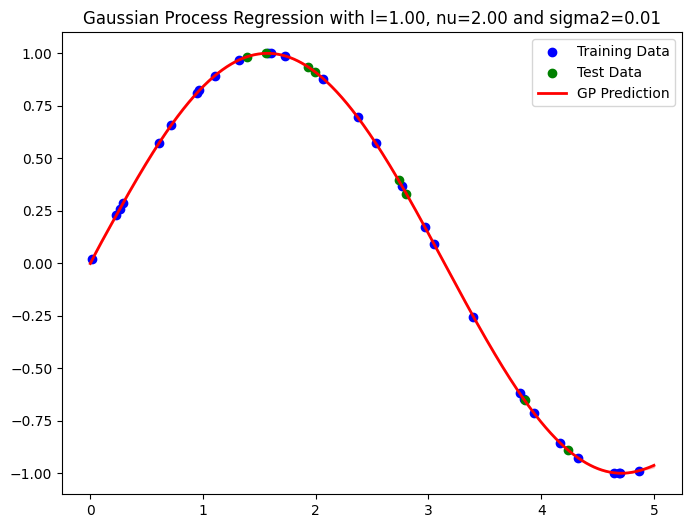

In [656]:
# On créé un modèle de krigeage gaussien
kernel = ConstantKernel(constant_value=sigma2) * Matern(length_scale=theta_opt[0], nu=theta_opt[1])



y_train_adjusted = y_train - custom_mean_function(X_train, beta)
y_test_adjusted = y_test - custom_mean_function(X_test, beta)

# Gaussian Process Regressor with custom mean function
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)


# On ajuste le modèle aux données d'entraînement
gp.fit(X_train, y_train_adjusted)

# Predictions
y_pred_adjusted, sigma = gp.predict(X_test, return_std=True)

# Add back the mean function to the predictions
y_pred = y_pred_adjusted + custom_mean_function(X_test, beta)

# On évalue la performance du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# On visualise les résultats
import matplotlib.pyplot as plt

x_plot = np.linspace(0, 5, 1000)[:, np.newaxis]
y_mean_adjusted, sigma = gp.predict(x_plot, return_std=True)
y_mean = y_mean_adjusted + custom_mean_function(x_plot, beta)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c='b', label='Training Data')
plt.scatter(X_test, y_test, c='g', label='Test Data')
plt.plot(x_plot, y_mean, 'r', lw=2, label='GP Prediction')
plt.fill_between(x_plot[:, 0], y_mean - 1.96 * sigma, y_mean + 1.96 * sigma, alpha=0.2, color='r')
plt.legend()
plt.title(f'Gaussian Process Regression with l={theta_opt[0]:.2f}, nu={theta_opt[1]:.2f} and sigma2={sigma2:.2f}')
plt.show()

[5.]
[607  27 883 478 172 796 781 136 202 849 149 314  29 204 173 987 830 257
 151 165 270  53 554 967 918  19  54 898 958 931]


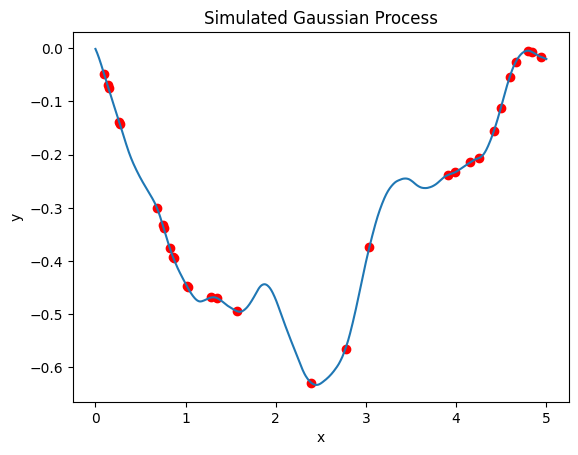

In [657]:
# Define the parameters
x = np.linspace(0, 5, 1000).reshape(-1, 1)
l = 1  
nu = 2.5
sigma2 = 0.1

# Create the kernel
kernel = ConstantKernel(constant_value=sigma2) * Matern(length_scale=l, nu=nu)

# Compute the covariance matrix
K = kernel(x)

# Simulate Gaussian process
y = np.random.multivariate_normal(np.zeros(len(x)), K, 1)

# select n_train random points from the dataset
indices = np.random.choice(np.arange(len(x)), ntrain, replace=False)
print(x[-1])
# indices  = np.arange(len(x), step=99)

X_train = x[indices]
y_train = y[:,indices][0]
print(indices)
# test set

indices_test = np.random.choice(np.arange(len(x)), n-ntrain, replace=False)

X_test = x[indices_test]
y_test = y[:,indices_test][0]


# Plot the result
plt.plot(x, y.T)
plt.scatter(X_train, y_train, c='r')
plt.title("Simulated Gaussian Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



In [658]:
# Log-transformed initial guess
log_theta0 = np.log([1.5, 2])  # Taking log of initial guess

# Define bounds for the parameters in the original space
bounds = Bounds([np.log(0.01),np.log( 0.1)], [np.log(10),np.log(1000)])  # Example bounds: [min_values], [max_values]

# Perform optimization with bounds
result_with_bounds = minimize(log_transformed_function_to_minimize, log_theta0, method='L-BFGS-B', bounds=bounds)
theta_opt = np.exp(result_with_bounds.x)

print("Optimisation success ? ", result_with_bounds.success)
print("Les paramètres optimaux sont : ", theta_opt)


sigma2est = sigma2ML(X_train, y_train, theta_opt)
print("La variance du bruit est : ", sigma2est)

# On calcule le vecteur de coefficients beta à partir des paramètres optimaux
beta = betaML(X_train, y_train, theta_opt)
print("Le vecteur de coefficients beta est : ", beta)


Optimisation success ?  True
Les paramètres optimaux sont :  [0.29036594 3.19734614]
La variance du bruit est :  0.002156617911866509
Le vecteur de coefficients beta est :  [ 0.01448962 -0.66430656  0.22847588 -0.01932089]


In [659]:
print("Comparaison avec les paramètres réels : ")
print("l = ", l)
print("l estimé  = ", theta_opt[0])
print()
print("nu = ", nu)
print("nu estimé  = ", theta_opt[1])
print()
print("sigma2 = ", sigma2)
print("sigma2 estimé  = ", sigma2est)
print()
print("beta estimé  = ", beta)



Comparaison avec les paramètres réels : 
l =  1
l estimé  =  0.2903659384545644

nu =  2.5
nu estimé  =  3.1973461426531617

sigma2 =  0.1
sigma2 estimé  =  0.002156617911866509

beta estimé  =  [ 0.01448962 -0.66430656  0.22847588 -0.01932089]


Mean Squared Error: 0.001629447459681962


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


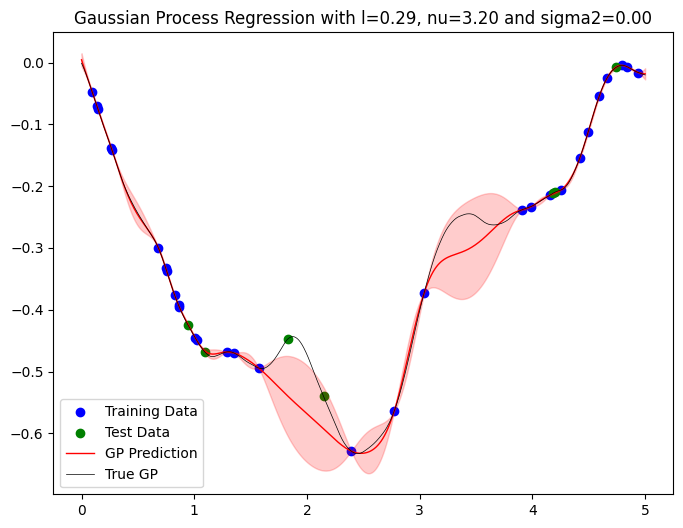

In [660]:
# On créé un modèle de krigeage gaussien
kernel = ConstantKernel(constant_value=sigma2est) * Matern(length_scale=theta_opt[0], nu=theta_opt[1])

y_train_adjusted = y_train - custom_mean_function(X_train, beta)
y_test_adjusted = y_test - custom_mean_function(X_test, beta)

# Gaussian Process Regressor with custom mean function
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)


# On ajuste le modèle aux données d'entraînement
gp.fit(X_train, y_train_adjusted)

# Predictions
y_pred_adjusted, sigma = gp.predict(X_test, return_std=True)

# Add back the mean function to the predictions
y_pred = y_pred_adjusted + custom_mean_function(X_test, beta)

# On évalue la performance du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# On visualise les résultats
import matplotlib.pyplot as plt

x_plot = np.linspace(0, 5, 1000)[:, np.newaxis]
y_mean_adjusted, sigma = gp.predict(x_plot, return_std=True)
y_mean = y_mean_adjusted + custom_mean_function(x_plot, beta)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c='b', label='Training Data')
plt.scatter(X_test, y_test, c='g', label='Test Data')
plt.plot(x_plot, y_mean, 'r', lw=1, label='GP Prediction')
plt.plot(x, y.T,"k", lw=0.5, label='True GP')
plt.fill_between(x_plot[:, 0], y_mean - 1.96 * sigma, y_mean + 1.96 * sigma, alpha=0.2, color='r')
plt.legend()
plt.title(f'Gaussian Process Regression with l={theta_opt[0]:.2f}, nu={theta_opt[1]:.2f} and sigma2={sigma2est:.2f}')
plt.show()

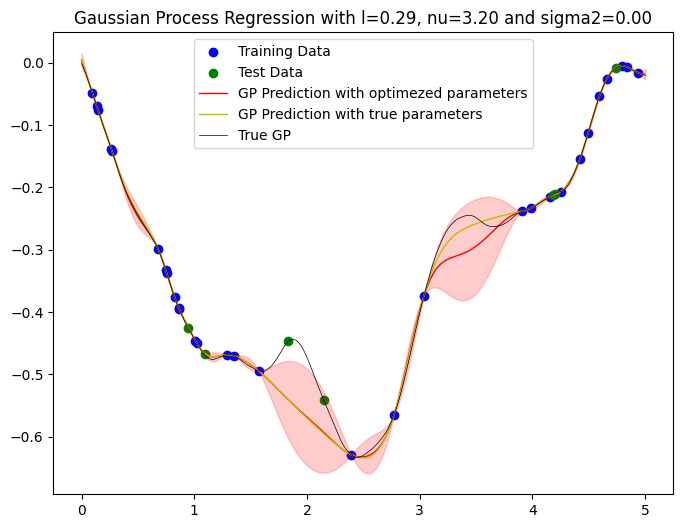

Mean Squared Error with optimized parameters: 0.001629447459681962
Mean Squared Error with true parameters: 0.0016533955960487592


In [661]:
## Krigeage avec les paramètres optimaux : 

kernel = ConstantKernel(constant_value=sigma2) * Matern(length_scale=l, nu=nu)

# Gaussian Process Regressor with custom mean function
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)


# On ajuste le modèle aux données d'entraînement
gp.fit(X_train, y_train_adjusted)

y_pred_adjusted_true_parameters, sigma = gp.predict(X_test, return_std=True)
# Add back the mean function to the predictions
y_pred_true_parameters = y_pred_adjusted_true_parameters + custom_mean_function(X_test, beta)



y_mean_adjusted_true_parameters, sigma = gp.predict(x_plot, return_std=True)
y_mean_true_parameters = y_mean_adjusted_true_parameters + custom_mean_function(x_plot, beta)


plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c='b', label='Training Data')
plt.scatter(X_test, y_test, c='g', label='Test Data')
plt.plot(x_plot, y_mean, 'r', lw=1, label='GP Prediction with optimezed parameters')
plt.plot(x_plot, y_mean_true_parameters, 'y', lw=1, label='GP Prediction with true parameters')
plt.plot(x, y.T,"k", lw=0.5, label='True GP')
plt.fill_between(x_plot[:, 0], y_mean - 1.96 * sigma, y_mean + 1.96 * sigma, alpha=0.2, color='r')
plt.legend()
plt.title(f'Gaussian Process Regression with l={theta_opt[0]:.2f}, nu={theta_opt[1]:.2f} and sigma2={sigma2est:.2f}')
plt.show()

# On évalue la performance du modèle
mse_optimized_parameters = mean_squared_error(y_pred, y_test)
mse_true_parameters = mean_squared_error(y_pred_true_parameters, y_test)
print(f'Mean Squared Error with optimized parameters: {mse_optimized_parameters}')
print(f'Mean Squared Error with true parameters: {mse_true_parameters}')


In [662]:
from tqdm import tqdm

x = np.linspace(0, 5, 1000).reshape(-1, 1)
l = 1  
nu = 2.5
sigma2 = 0.1
# Create the kernel
kernel_true_parameters = ConstantKernel(constant_value=sigma2) * Matern(length_scale=l, nu=nu)
# Compute the covariance matrix
K = kernel(x)


list_l_opt = []
list_nu_opt = []    
list_sigma2_opt = []
list_beta_opt = []
mse_optimized_parameters = []
mse_true_parameters = []


for i in tqdm(range(100)):

    # Simulate Gaussian process
    y = np.random.multivariate_normal(np.zeros(len(x)), K, 1)

    # select n_train random points from the dataset
    # select n_train random points from the dataset
    indices = np.random.choice(np.arange(len(x)), ntrain, replace=False)
    X_train = x[indices]
    y_train = y[:,indices][0]
    # test set
    # Log-transformed initial guess
    log_theta0 = np.log([1.5, 2])  # Taking log of initial guess
    # Define bounds for the parameters in the original space
    bounds = Bounds([np.log(0.01),np.log( 0.1)], [np.log(10),np.log(1000)])  # Example bounds: [min_values], [max_values]
    # Perform optimization with bounds
    result_with_bounds = minimize(log_transformed_function_to_minimize, log_theta0, method='L-BFGS-B', bounds=bounds)
    theta_opt = np.exp(result_with_bounds.x)
    sigma2est = sigma2ML(X_train, y_train, theta_opt)
    beta = betaML(X_train, y_train, theta_opt)
    list_l_opt.append(theta_opt[0])
    list_nu_opt.append(theta_opt[1])
    list_sigma2_opt.append(sigma2est)
    list_beta_opt.append(beta)

    kernel = ConstantKernel(constant_value=sigma2est) * Matern(length_scale=theta_opt[0], nu=theta_opt[1])
    gp= GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)
    y_train_adjusted = y_train - custom_mean_function(X_train, beta)
    gp.fit(X_train, y_train_adjusted)
    y_pred_adjusted, sigma = gp.predict(X_test, return_std=True)
    y_pred = y_pred_adjusted + custom_mean_function(X_test, beta)

    mse_optimized_parameters.append(mean_squared_error(y_pred, y_test))

    # Gaussian Process Regressor with custom mean function
    gp = GaussianProcessRegressor(kernel=kernel_true_parameters, n_restarts_optimizer=0)
    # On ajuste le modèle aux données d'entraînement
    y_train_adjusted = y_train
    gp.fit(X_train, y_train_adjusted)
    y_pred_adjusted_true_parameters, sigma = gp.predict(X_test, return_std=True)
    # Add back the mean function to the predictions
    y_pred_true_parameters = y_pred_adjusted_true_parameters + custom_mean_function(X_test, beta)
    mse_true_parameters.append(mean_squared_error(y_pred_true_parameters, y_test))


    




print("l = ", np.mean(list_l_opt))
print("nu = ", np.mean(list_nu_opt))
print("sigma2 = ", np.mean(list_sigma2_opt))
print("beta = ", np.mean(list_beta_opt, axis=0))


  4%|▍         | 4/100 [00:05<02:18,  1.44s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  7%|▋         | 7/100 [00:09<02:04,  1.34s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  9%|▉         | 9/100 [00:11<01:50,  1.21s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages

l =  0.47195557633506013
nu =  3.489449020641104
sigma2 =  0.013951904129438952
beta =  [-0.02888267  0.00047941  0.00151079  0.00023477]


In [663]:
print("MSE optimized parameters = ", np.mean(mse_optimized_parameters))
print("MSE true parameters = ", np.mean(mse_true_parameters))

MSE optimized parameters =  0.23074960338709136
MSE true parameters =  0.4645049184213403
